# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

Importing Modules

In [1]:
!pip install fast_ml

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from fast_ml.model_development import train_valid_test_split

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels

import time


Importing Dataframe

In [3]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=['datetime'], parse_dates=['datetime'])

Viewing the first 5 rows in the dataframe

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Viewing the dataframe info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:title={'center':'number of orders'}, xlabel='datetime'>

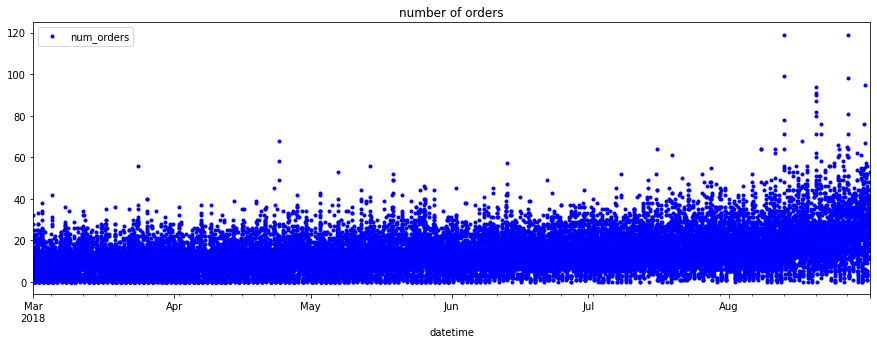

In [6]:
df.plot(style='.', figsize=(15, 5), color = 'blue', title='number of orders')


Viewing the amount of duplicates in the dataframe

In [7]:
df.duplicated().sum()

26415

Viewing the amount of null values in the dataframe

In [8]:
df.isna().sum()

num_orders    0
dtype: int64

Looking at the description of the dataframe. Interesting to see the mean is around 14 orders and there is a std of 9.

In [9]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [10]:
df = df.resample('1h').sum().sort_index()

In [11]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

Viewing a small selection of a week to look at the peaks and valleys within a week. We can see peak of orders around 175 and some valleys that are close to 0.

<AxesSubplot:xlabel='datetime'>

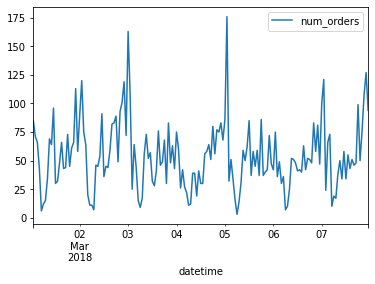

In [12]:
df.loc[(df.index > '03-01-2018') & (df.index < '03-08-2018')].plot()


Created a function to make new columns in the dataframe to be able to investigate and analyze the data at a higher level.

In [13]:
def make_features(df, target="num_orders", window_size=6, n_lag=20):
  df_copy = df.copy()
  df_copy['rolling_mean'] = df_copy[target].shift().rolling(window_size).mean()
  for lag in range(1, n_lag + 1):
    df_copy["lag_{}".format(lag)] = df_copy[target].shift(lag)
  df_copy['dayofweek'] = df_copy.index.dayofweek
  df_copy['month'] = df_copy.index.month
  df_copy['week'] = df_copy.index.week
  df_copy['dayofmonth'] = df_copy.index.day
  df_copy['hour'] = df_copy.index.hour
  df_copy['is_weekend'] = df_copy.dayofweek.isin([5,6])*1
  df_copy = df_copy.dropna()
  return df_copy

Created the features that are going into the dataframe and called it a different name because it is a copied version of the dataframe, that way we can always look at the original dataframe.

In [14]:
df_copied = make_features(df)

In [15]:
df_copied

,num_orders,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_17,lag_18,lag_19,lag_20,dayofweek,month,week,dayofmonth,hour,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,61,53.166667,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,...,66.0,71.0,85.0,124.0,3,3,9,1,20,0
2018-03-01 21:00:00,66,55.333333,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,...,43.0,66.0,71.0,85.0,3,3,9,1,21,0
2018-03-01 22:00:00,113,55.333333,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,...,6.0,43.0,66.0,71.0,3,3,9,1,22,0
2018-03-01 23:00:00,58,67.000000,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,...,12.0,6.0,43.0,66.0,3,3,9,1,23,0
2018-03-02 00:00:00,90,69.333333,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,15.0,12.0,6.0,43.0,4,3,9,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,172.666667,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,...,230.0,194.0,276.0,246.0,4,8,35,31,19,0
2018-08-31 20:00:00,154,167.666667,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,4,8,35,31,20,0
2018-08-31 21:00:00,159,171.166667,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,4,8,35,31,21,0


During the hours of 12 a.m. to 3 a.m. there is a surge in the amount of orders. My hypothesis, is people trying to get home from nightlife activities such as clubs, bars, etc. The other small surge is around 4-5 p.m., probably because of people coming home from work. Need to do more investigating to confirm the hypotheses.  

Text(0.5, 1.0, 'Orders by Hour')

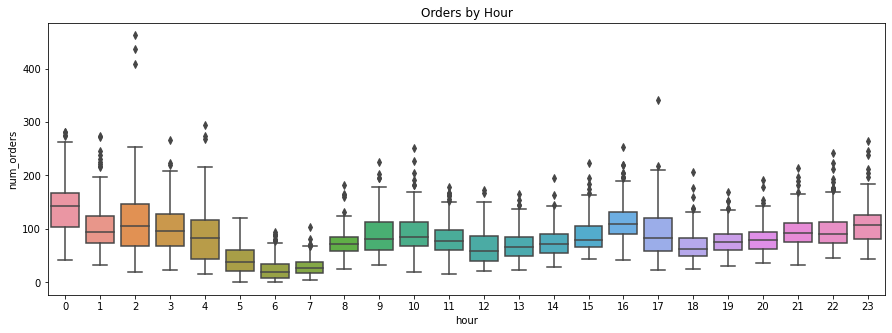

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df_copied, x='hour', y='num_orders')
ax.set_title('Orders by Hour')

Viewing the number of orders by month. August seems to have the highest number of orders and March has the lowest number, perhaps because of cold weather?! Need to do more investigating to confirm the hypothesis

Text(0.5, 1.0, 'Orders by Month')

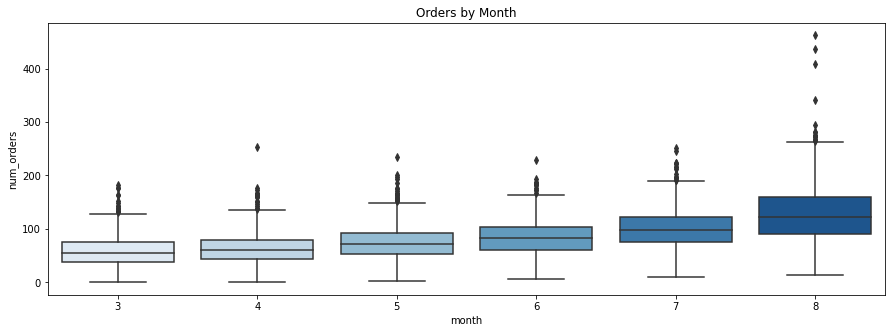

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df_copied, x='month', y='num_orders', palette='Blues')
ax.set_title('Orders by Month')

Viewing the trend. The trend is ascending as we get into the summer months. 

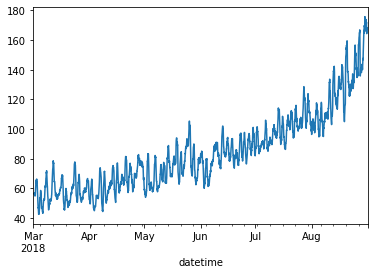

In [18]:
result = seasonal_decompose(df, model='additive')
result.trend.plot()
plt.show()

The seasonality has amplitude swings of around 120, (from -60 to 60) and it is on the same days that had peaks on the original plot.

<AxesSubplot:xlabel='datetime'>

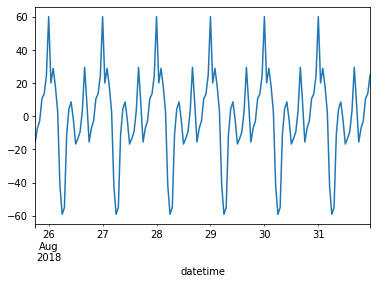

In [19]:
result.seasonal[-150:].plot()

Created a RMSE function to be able to reuse this function.

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Training/Testing

Created a features and target variable and then used train test split on the data. 90% of the data is in the training set, while 10% is in the test set.

In [21]:
X = df_copied.drop(['num_orders'], axis = 1)
y = df_copied['num_orders']

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, shuffle=False) 

In [22]:
# print(f'train: {X_train.index.min(), X_train.index.max()}')
# print(f'validation: {X_valid.index.min(), X_valid.index.max()}')
# print(f'test: {X_test.index.min(), X_test.index.max()}')

Linear Regression Model Training/Baseline

In [23]:
# Start time
st = time.time()

model = LinearRegression()
model.fit(X_train, y_train) 

pred_train = model.predict(X_train)
pred_test = model.predict(X_valid)

print("RMSE for the validation set: ",  rmse(y_valid, pred_test))

# End time
et = time.time()
linear_elapsed_time = et - st

RMSE for the validation set:  39.010419609714006


Linear Regression Execution Time

In [24]:
print('LinearRegressor Execution time:', linear_elapsed_time, 'seconds')

LinearRegressor Execution time: 0.04961371421813965 seconds


Random Forest Regressor Model

In [25]:
param_grid ={'n_estimators': range(50, 60, 5),
            'max_depth': range(8,16,4),
            'min_samples_split': range(10,40,10),
            'max_features':range(3,10,2)}

Random Forest Regression Model Training

In [26]:
# Start time
st = time.time()

rfr_model = RandomForestRegressor(random_state=12345, n_jobs = -1)
rfr_model.fit(X_train, y_train)

pred_train = rfr_model.predict(X_train)
pred_test = rfr_model.predict(X_valid)

print("RMSE for the validation set: ",  rmse(y_valid, pred_test))

# End time
et = time.time()
rfr_elapsed_time = et - st

RMSE for the validation set:  31.221874365401078


In [27]:
print('RandomForestRegressor Execution time:', rfr_elapsed_time, 'seconds')

RandomForestRegressor Execution time: 6.212832689285278 seconds


RFRM using Time Series Split

In [28]:
param_grid ={'n_estimators': range(50, 60, 5),
            'max_depth': range(8,16,4),
            'min_samples_split': range(10,40,10),
            'max_features':range(3,10,2)}

In [29]:
model = RandomForestRegressor(n_estimators=100)
tscv = TimeSeriesSplit(n_splits=5)
gscv = GridSearchCV(model, scoring='neg_root_mean_squared_error', param_grid=param_grid, n_jobs=4, cv=tscv).fit(X_train, y_train)
best_params = gscv.best_params_
print(best_params)

{'max_depth': 12, 'max_features': 9, 'min_samples_split': 10, 'n_estimators': 50}


In [30]:
rfr_model = RandomForestRegressor(max_depth=12, max_features=9, min_samples_split=10, n_estimators=55)
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_valid)

print("RMSE for the validation set: ",  rmse(y_valid, y_pred))

RMSE for the validation set:  32.643850230658884


XGBoost Training

In [31]:
# Start time
st = time.time()

xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_valid)
xgb_rmse = np.sqrt(mean_squared_error(y_valid, xgb_pred))
print(f'RMSE XG Boost: {xgb_rmse}.')

# End time
et = time.time()
xgb_elapsed_time = et - st

RMSE XG Boost: 32.05811125574697.


XGBoostRegressor Elapsed Time

In [32]:
print('XG-Boost Execution time:', xgb_elapsed_time, 'seconds')

XG-Boost Execution time: 31.51839280128479 seconds


Training XG-Boost to get a low RMSE score.

In [33]:
# Start time
st = time.time()

trainval_xg = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
trainval_xg.fit(X_train_valid, y_train_valid)

xgb_pred = trainval_xg.predict(X_test)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f'RMSE XG Boost on Test Set: {xgb_test_rmse}.')

# End time
et = time.time()
xgb_elapsed_time = et - st

RMSE XG Boost on Test Set: 44.2452542907851.


Creating an array with the predictions

In [34]:
y['prediction'] = xgb_model.predict(X_test)

Viewing that it is the type ndarray

In [35]:
print(type(y['prediction']))

<class 'numpy.ndarray'>


Turning the array into a dataframe

In [36]:
df_prediction = pd.DataFrame(y['prediction'], columns=['prediction'])
df_prediction

,prediction
0,133.010468
1,117.417923
2,99.175339
3,84.512062
4,81.408493
...,...
435,113.567230
436,100.104965
437,160.225906
438,130.281479


Merging the prediction dataframe with the copied dataframe

In [37]:
df_merged = df_copied.merge(df_prediction, how='outer', left_index=True, right_index=True)
df_merged

,num_orders,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_18,lag_19,lag_20,dayofweek,month,week,dayofmonth,hour,is_weekend,prediction
2018-03-01 20:00:00,61.0,53.166667,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,...,71.0,85.0,124.0,3.0,3.0,9.0,1.0,20.0,0.0,NaN
2018-03-01 21:00:00,66.0,55.333333,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,...,66.0,71.0,85.0,3.0,3.0,9.0,1.0,21.0,0.0,NaN
2018-03-01 22:00:00,113.0,55.333333,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,...,43.0,66.0,71.0,3.0,3.0,9.0,1.0,22.0,0.0,NaN
2018-03-01 23:00:00,58.0,67.000000,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,...,6.0,43.0,66.0,3.0,3.0,9.0,1.0,23.0,0.0,NaN
2018-03-02 00:00:00,90.0,69.333333,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,12.0,6.0,43.0,4.0,3.0,9.0,2.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.567230
436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.104965
437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.225906
438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.281479


Plotting the new predictions and the real number of orders

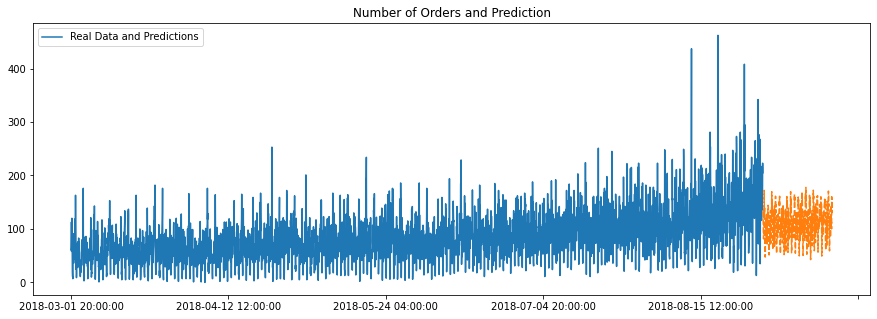

In [38]:
ax = df_merged[['num_orders']].plot(figsize=(15, 5))
df_merged['prediction'].plot(ax=ax, style='--')
plt.legend(['Real Data and Predictions'])
ax.set_title('Number of Orders and Prediction')
plt.show()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good!

</div>

# Conclusion

We found a few models that fit the description of getting the RMSE under 48. XGBoostRegressor came out with a RMSE for the validation set:  32.0581 but on the test set the RMSE came in at 44.2452, which is lower than our goal of less than 48. Our RandomForestRegressor concluded with a RMSE for the validation set:  31.2218, which is a great score but since it takes longer I chose to stick with the XG Boost Regressor which is more efficient and very close in score. We can use the XGBoostRegressor to view our predictions at a higher accuracy than the other models and make predictions for the Sweet Lift Taxi to help get more customers.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48